## Importing Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gzip
import requests
import itertools

from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from timeit import default_timer as timer
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader

%matplotlib inline

## Define the device 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define the path for the dataset

In [3]:
PATH = os.path.join(os.getcwd(), "mnist")


if not os.path.exists(PATH):
    os.makedirs(PATH)

## Reading the Dataset and Preprocessing

---
### A little information about the MNIST dataset

- The dataset is stored in a ubyte format.
- From the author's website, we can get a little more information about the dataset.
<br><br>
There are 4 files:
    - train-images-idx3-ubyte: training set images
    - train-labels-idx1-ubyte: training set labels
    - t10k-images-idx3-ubyte:  test set images
    - t10k-labels-idx1-ubyte:  test set labels

The training set contains 60000 examples, and the test set 10000 examples.


http://yann.lecun.com/exdb/mnist/

---

---
- We can write a function to read the ubyte files.
- First, we will check if the files are already downloaded in our desired folder.
- If they don't exist, we can download them from the website.
<br><br>
- After either checking if they exist, or downloading them, we then decompress the files and read them as a numpy array using the frombuffer function.
---

In [4]:
def read(path, url):
    if os.path.isfile(path):
        with open(path, "rb") as f:
            raw_data = f.read()
            processed_data = np.frombuffer(gzip.decompress(raw_data), dtype = np.uint8).copy()
    else:
        with open(path, "wb") as f:
            raw_data = requests.get(url).content
            f.write(raw_data)
            processed_data = np.frombuffer(gzip.decompress(raw_data), dtype = np.uint8).copy()    
    
    return processed_data

---
- Now we can define our train and test files, as they are already provided for us in that format
- Our function defined above will take in 2 arguments; the first is the path to save the data, and the next, is to download the data from the website, and read it as numpy arrays
---

In [5]:
X_train = read(os.path.join(PATH, "train-images-idx3-ubyte.gz"), "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
y_train = read(os.path.join(PATH, "train-labels-idx1-ubyte.gz"), "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")
X_test = read(os.path.join(PATH, "t10k-images-idx3-ubyte.gz"), "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")
y_test = read(os.path.join(PATH, "t10k-labels-idx1-ubyte.gz"), "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")

- We can check the shapes of the dataset as a sanity check

In [6]:
X_train = X_train[16:]
y_train = y_train[8:]
X_test = X_test[16:]
y_test = y_test[8:]


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(47040000,)
(60000,)
(7840000,)
(10000,)


---
- We know that there should be 60000 images in the training set and 10000 images in the test set.
- Now we can see that there are in fact about 60000 labels in the train set and about 10000 labels in the test set.
- But there seem to be some extra values.
<br><br><br>
- Upon reading the docs, we find out that:-
<br><br>
- For all the test files:-
    - The first 4 bytes contain the magic number (check outmagic numbers).
    - The next 4 bytes contain the information about the number of items.
    - The labels start from the 9th byte
    - So, in terms of Python indexing, bytes 0:7 are of virtually no use to us.
    - This means, we will get exactly 60000 labels (60008 - 8 according to python indexing).
<br><br>
- For all the train files:- 
    - The first 4 bytes contain the magic number
    - The next 4 bytes contain the number of images.
    - The 8 bytes after that contain the information about the number of rows and the number of columns
    - This means we can slice the first 16 elements.
    - Hence, we end up with 47,040,000 elements.
    
---

- Since the images are of the shape 28 x 28, we can red them as a 1 dimensional array.
- Hence, the shape of our train dataset will be (Num_Images, 28*28)
- Simillarly, the test dataset will have the shape (Num_Images, 28*28)
---

In [7]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


---
- Now we have a dataset that makes sense.
- We have 60000 images of shape 28x28x1, and corresponding 60000 labels
<br><br>
- Similarly, we have 10000 images of shape 28x28x1, and corresponding 10000 labels
---
- Now we can try to plot an image and it's corresponding label to see if it matches up
---

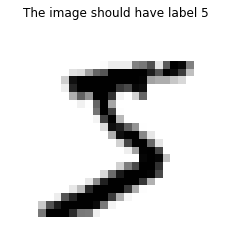

In [8]:
index = 0

digit = X_train[index].reshape(28, 28)
plt.imshow(digit, cmap = mpl.cm.binary)
plt.title(f"The image should have label {y_train[index]}")
plt.axis("off")
plt.show()

---
- We can verify that the label and the image match by changing the index to any value.
- As long as it matches up, we know that we have loaded our dataset properly.
---

- We can also do some other visualizations
---

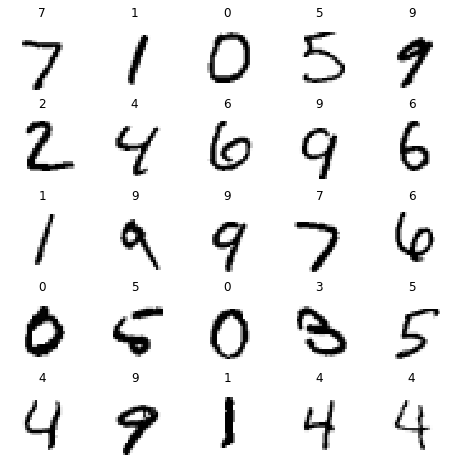

In [9]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (8, 8))
fig.subplots_adjust(hspace = .3)

for i in range(5):
    for j in range(5):
        ax[i][j].axis("off")
        ax[i][j].imshow(X_test[i + (j * 5), :].astype(np.uint8).reshape(28, 28), cmap = mpl.cm.binary)
        ax[i][j].set_title(y_test[i + (j * 5)])

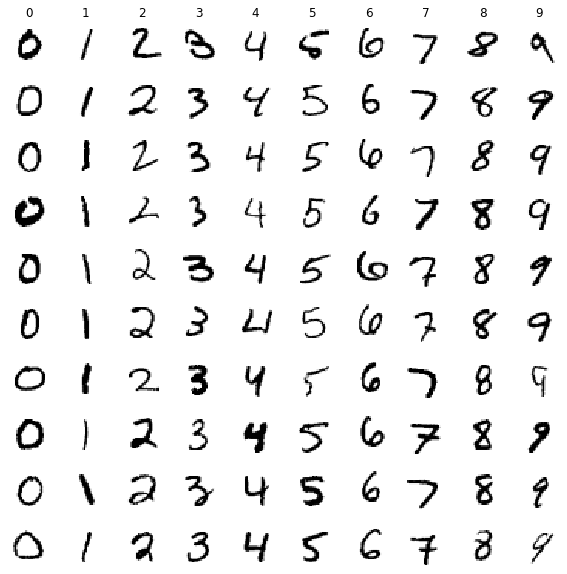

In [10]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize = (10, 10))
fig.subplots_adjust(hspace = .3)

for i in range(10):
    num_i = X_test[y_test == i]
    ax[0][i].set_title(i)
    
    for j in range(10):
        ax[j][i].axis("off")
        ax[j][i].imshow(num_i[j, :].astype(np.uint8).reshape(28, 28), cmap = mpl.cm.binary)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)
(10000, 784)
(10000,)


In [13]:
train_trans =  transforms.Compose([transforms.ToPILImage(),
                                   transforms.RandomRotation(degrees = 15),
                                   transforms.ColorJitter(),
                                   transforms.GaussianBlur(kernel_size = 3),
                                   transforms.CenterCrop(size = 28),
                                   transforms.ToTensor(),
                                  ])
                    
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.CenterCrop(size = 28),
                                  transforms.ToTensor(),
                                 ])
                   
test_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.CenterCrop(size = 28),
                                  transforms.ToTensor(),
                                 ])

In [14]:
class MNISTDataLoader(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms = None):
        self.X = images = images
        self.y = labels
        self.transforms = transforms
        
    
    def __len__(self):
        return len(self.X)
    
    
    def __getitem__(self, i):
        data = self.X[i, :]
        
        data = data.astype(np.uint8).reshape(28, 28, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
    
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [15]:
train_set = MNISTDataLoader(X_train, y_train, train_trans)
valid_set = MNISTDataLoader(X_val, y_val, valid_trans)
test_set = MNISTDataLoader(X_test, y_test, test_trans)

In [16]:
class Network(nn.Module):
    def __init__(self, input_channels = 1, num_classes = 10):
        super(Network, self).__init__()
        
        self.features = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size = 5, stride = 1, padding = 2),
                                      nn.BatchNorm2d(num_features = 32),
                                      nn.MaxPool2d(kernel_size = 2, stride = 2),
                                      nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2),
                                      nn.BatchNorm2d(num_features = 64),
                                      nn.MaxPool2d(kernel_size = 2, stride = 2),
                                      nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                      nn.BatchNorm2d(num_features = 128),
                                      nn.MaxPool2d(kernel_size = 2, stride = 1)
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(128 * 6 * 6, 1024),
                                        nn.BatchNorm1d(num_features = 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512), 
                                        nn.BatchNorm1d(num_features = 512),
                                        nn.ReLU(), 
                                        nn.Linear(512, 256), 
                                        nn.BatchNorm1d(num_features = 256),
                                        nn.ReLU(), 
                                        nn.Linear(256, 64), 
                                        nn.BatchNorm1d(num_features = 64),
                                        nn.ReLU(), 
                                        nn.Linear(64, num_classes),
                                       )
       
    
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 6 * 6)
        x = self.classifier(x)
        return x

In [17]:
lr = 0.001
batch_size = 256
epochs = 20
n_classes = 10

In [18]:
model = Network().to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [19]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [20]:
def train(model, criterion, optimizer, train_loader, valid_loader, save_file_name, max_epochs_stop = 5,
          n_epochs = 100, print_every = 1):

    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    try:
        print(f"Model has been trained for: {model.epochs} epochs\n")
    except:
        model.epochs = 0
        print(f"Starting Training from Scratch.\n")

    overall_start = timer()

    
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for ii, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            output = model(data)

            _, pred = torch.max(output, dim = 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
            loss = criterion(output, target)
            train_loss += loss.item() * data.size(0)

            loss.backward()
            optimizer.step()

            print(f"Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.", end = "\r")

        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()

                for data, target in valid_loader:
                    data, target = data.to(device), target.type(torch.LongTensor).to(device)

                    output = model(data)
                    _, pred = torch.max(output, dim = 1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % print_every == 0:
                    print(f"\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f}\t         || \tValidation Loss: {valid_loss:.4f}")
                    print(f"\t\tTraining Accuracy: {100 * train_acc:.2f}%\t || \tValidation Accuracy: {100 * valid_acc:.2f}%")
                    print("=" * 100)
                    
                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= max_epochs_stop:
                        print(f"\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%")
                        total_time = timer() - overall_start
                        print(f"{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.")

                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer

                        history = pd.DataFrame(history, columns = ['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
                        return model, history

    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(f"\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%")
    print(f"{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.")
    print("\n")

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

    return model, history

In [21]:
model, history = train(model, 
                       criterion, 
                       optimizer, 
                       train_loader, 
                       valid_loader, 
                       save_file_name = "MNIST.pt", 
                       max_epochs_stop = 5,
                       n_epochs = 20, 
                       print_every = 1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 17.72 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.2601	         || 	Validation Loss: 0.0982
		Training Accuracy: 95.42%	 || 	Validation Accuracy: 97.48%
Epoch: 1	100.00% complete. 15.77 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0761	         || 	Validation Loss: 0.0622
		Training Accuracy: 97.97%	 || 	Validation Accuracy: 98.28%
Epoch: 2	100.00% complete. 16.02 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.0558	         || 	Validation Loss: 0.0572
		Training Accuracy: 98.39%	 || 	Validation Accuracy: 98.52%
Epoch: 3	100.00% complete. 15.90 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0467	         || 	Validation Loss: 0.0431
		Training Accuracy: 98.60%	 || 	Validation Accuracy: 98.77%
Epoch: 4	100.00% complete. 15.51 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.0362	         || 	Validation Loss: 0.0464
		Training Accuracy: 98.94%	 || 	Validation Accuracy: 98.70%
Epoch: 5	100.00% compl

---
- We can plot the evaluation metrics
---

Text(0.5, 1.0, 'Training and Validation Loss')

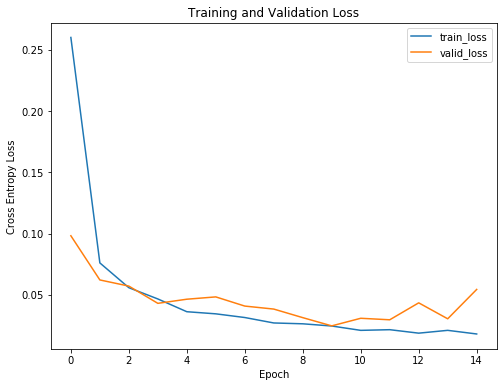

In [22]:
plt.figure(figsize = (8, 6))

for c in ["train_loss", "valid_loss"]:
    plt.plot(history[c], label = c)
    
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Accuracy')

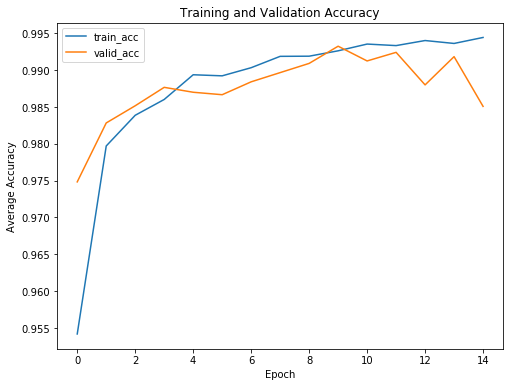

In [23]:
plt.figure(figsize = (8, 6))

for c in ["train_acc", "valid_acc"]:
    plt.plot(history[c], label = c)
    
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Accuracy")
plt.title("Training and Validation Accuracy")

---
- Next we can save the model weights
---

In [24]:
def save_checkpoint(model, path):
    checkpoint = {}
    checkpoint["epochs"] = model.epochs
    checkpoint["classifier"] = model.classifier
    checkpoint["state_dict"] = model.state_dict()
    checkpoint["optimizer"] = model.optimizer
    checkpoint["optimizer_state_dict"] = model.optimizer.state_dict()
    
    torch.save(checkpoint, path)

In [25]:
save_checkpoint(model, path = "./MNIST.pth")

---
# Inference
---

---
- We can start by loading in the model and checking the parameters to see if it is loaded correctly
---

In [26]:
class Network(nn.Module):
    def __init__(self, input_channels = 1, num_classes = 10):
        super(Network, self).__init__()
        
        self.features = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size = 5, stride = 1, padding = 2),
                                      nn.BatchNorm2d(num_features = 32),
                                      nn.MaxPool2d(kernel_size = 2, stride = 2),
                                      nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2),
                                      nn.BatchNorm2d(num_features = 64),
                                      nn.MaxPool2d(kernel_size = 2, stride = 2),
                                      nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                      nn.BatchNorm2d(num_features = 128),
                                      nn.MaxPool2d(kernel_size = 2, stride = 1)
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(128 * 6 * 6, 1024),
                                        nn.BatchNorm1d(num_features = 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512), 
                                        nn.BatchNorm1d(num_features = 512),
                                        nn.ReLU(), 
                                        nn.Linear(512, 256), 
                                        nn.BatchNorm1d(num_features = 256),
                                        nn.ReLU(), 
                                        nn.Linear(256, 64), 
                                        nn.BatchNorm1d(num_features = 64),
                                        nn.ReLU(), 
                                        nn.Linear(64, num_classes),
                                       )
       
    
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 6 * 6)
        x = self.classifier(x)
        return x

In [27]:
print(model)

Network(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(i

In [28]:
def load_checkpoint(path):
    
    checkpoint = torch.load(path)
    
    model = Network()
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = checkpoint["classifier"]
    
    model.load_state_dict(checkpoint["state_dict"])
    
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f'Total Parameters: {total_params:,}')
    print(f'Total gradient parameters: {total_trainable_params:,}')
    
    model.epochs = checkpoint['epochs']

    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [29]:
model, optimizer = load_checkpoint(path = "./MNIST.pth")

Total Parameters: 5,522,954
Total gradient parameters: 5,396,554


---
- We can check the accuracy of our model by using the function below.
- Here, we will calculate the Top-k accuracy, which means that will give the output of the top K predictions from the total number of classes.
---

In [30]:
def accuracy(output, target, topk = (1, )):
    output = output.to(device)
    target = target.type(torch.LongTensor).to(device)
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(k = maxk, dim = 1, largest = True, sorted = True)
        pred = pred.t()
        
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        res = []
        
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim = True)
            res.append(correct_k.mul_(100 / batch_size).item())
            
        return res

---
- We can test out our model on the test set.
- We will start by creating a dummy confusion matrix.
- Then, for each image, we will make a prediction.
- For each prediction made, we will evaluate it and append the count to the confusion matrix.
- This way, we will be avle to tell about the True and False predictions, and will also give an idea about how to handle our dataset
---

In [31]:
def evaluate(model, test_loader, criterion, topk = (1, 3, 5)):
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.type(torch.LongTensor).to(device)

            out = model(data)
            _, predscm = torch.max(out, 1)
            
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            for pred, true in zip(out, targets):
                acc_results[i, :] = accuracy(pred.unsqueeze(0), true.unsqueeze(0), topk)
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1


    return confusion_matrix

criterion = nn.CrossEntropyLoss()
confusion_matrix = evaluate(model, test_loader, criterion)

In [32]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix.png')
    return plt

Confusion matrix, without normalization


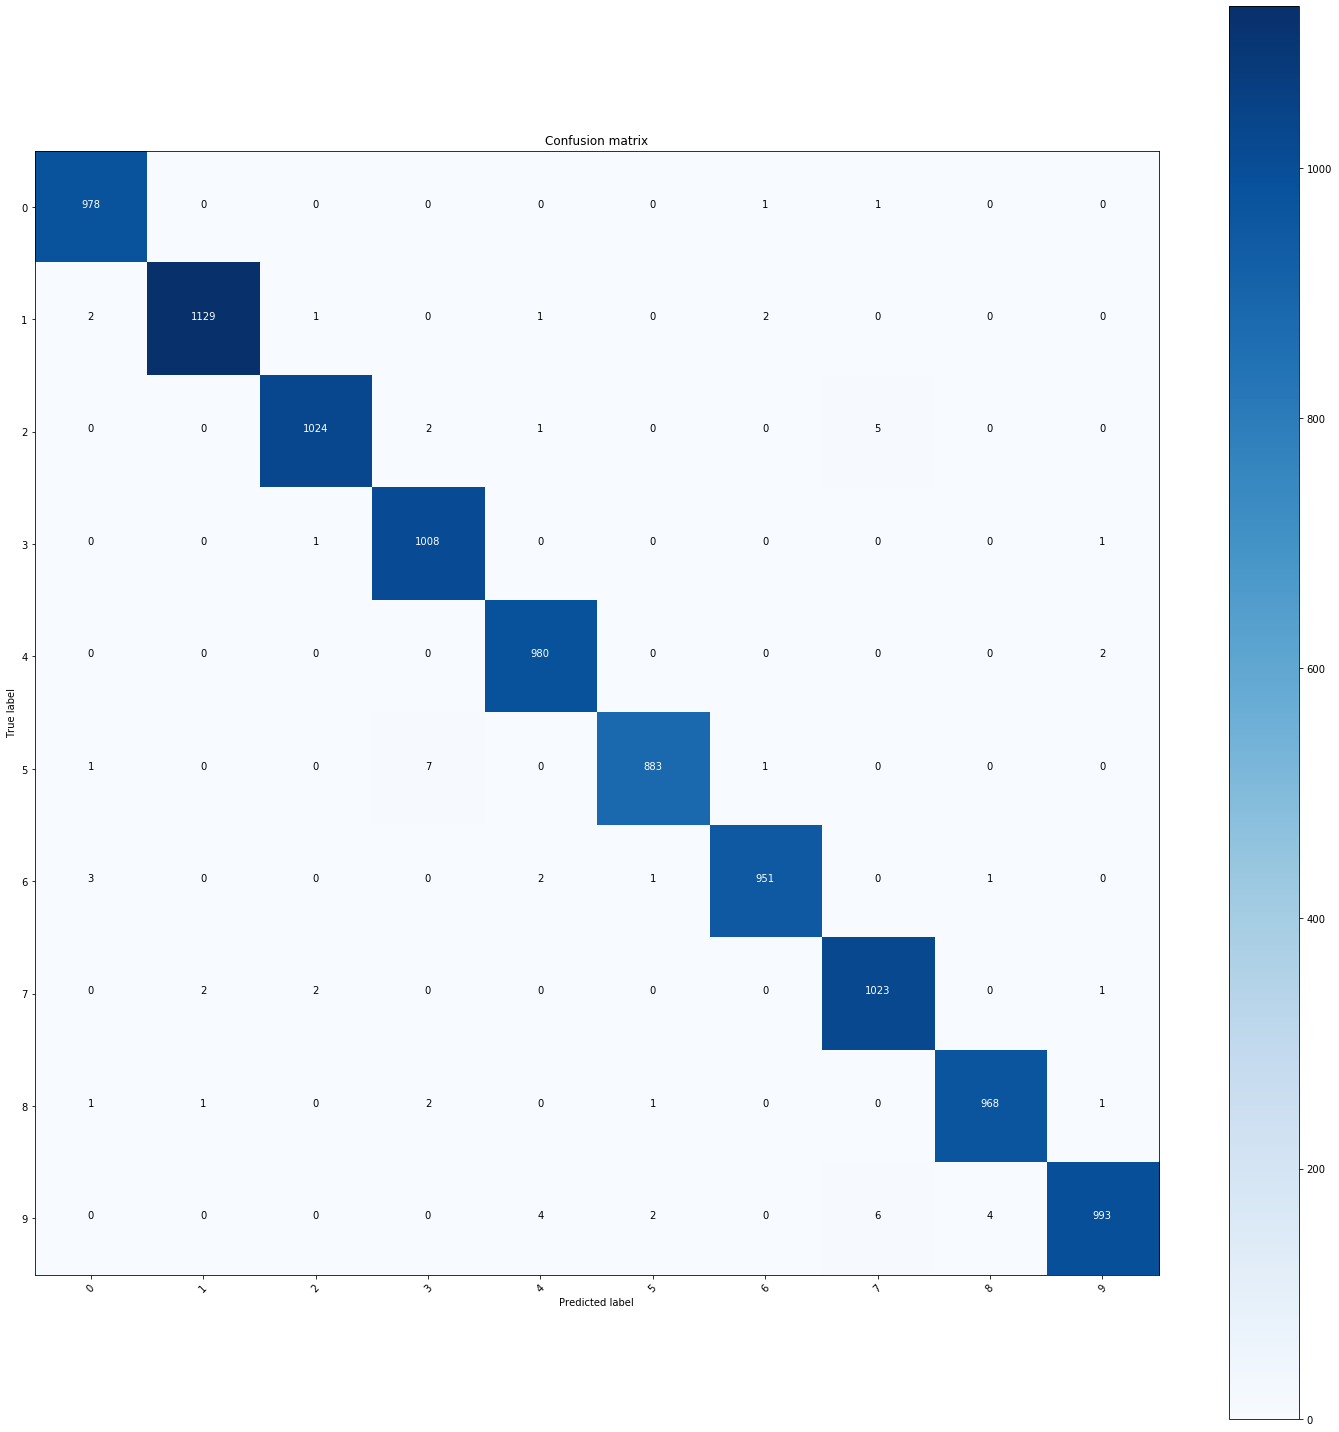

In [33]:
classnames = [i for i in range(0, n_classes)]


plt.figure(figsize = (20, 20))
plt = plot_confusion_matrix(confusion_matrix, classnames)

---
- If we want to test a custom image, we need to perform the same preprocessing operations as we did on our training set, so that it will be compatible with our model.
- For our training set, we require our images to be of the size (28, 28), so we will resize the image first.
- Then we will normalize it and convert it to a tensor.
- We can then predict the image.
---

In [34]:
def process_image(image_path):
    image = Image.open(image_path)
    img = image.resize((30, 30))
    
    width = 30
    height = 30
    new_width = 28
    new_height = 28
    
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))
    img = ImageOps.grayscale(img)
    img = ImageOps.invert(img)
    
    img = np.array(img).reshape(28, 28, 1).transpose((2, 0, 1)) / 255.0

    img_tensor = torch.Tensor(img)

    return img_tensor

In [35]:
def imshow_tensor(image, ax = None, title = None):
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose(1, 2, 0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    image = np.clip(image, 0, 1)

    ax.imshow(image, cmap = mpl.cm.binary)
    plt.axis('off')

    return ax, image

- We can define the classes as a dictionary, so it will be easier to make the topk prediction

In [36]:
classes = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", }

---
- The Predict function will also give the Top-k prediction on the image
- The prediction is clipped to give a value between 0 and 1
---

In [37]:
def predict(image_path, model, topk = 5):
    real_class = image_path.split("_")[-1]
    
    img_tensor = process_image(image_path)
    img_tensor = img_tensor.view(1, 1, 28, 28)

    with torch.no_grad():
        model = model.to("cpu")
        model.eval()

        out = model(img_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(topk, dim = 1)

        top_classes = [classes[i] for i in topclass.cpu().numpy()[0]]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

---
---
---

# Testing
---

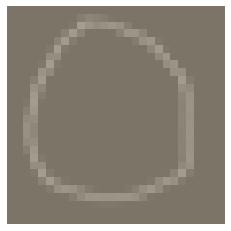

In [38]:
_ = imshow_tensor(process_image("./digit_0.png"))

In [39]:
def display_prediction(image_path, model, topk):
    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index = classes)

    plt.figure(figsize = (16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img.reshape(1, 28, 28), ax = ax)
    
    ax.set_title("True Prediction: " + str(y_obs.split(".", 1)[0]), size = 20)

    ax = plt.subplot(1, 2, 2)
    result.sort_values('p')['p'].plot.barh(color = 'blue', edgecolor = 'k', ax = ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

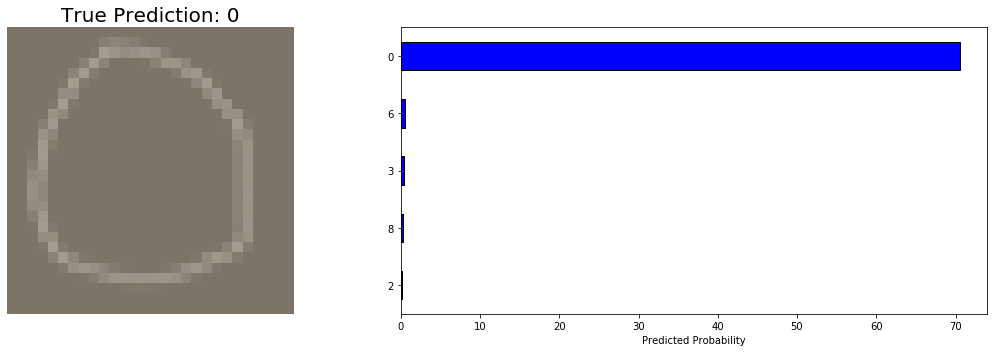

In [40]:
display_prediction("./digit_0.png", model, topk = 5)

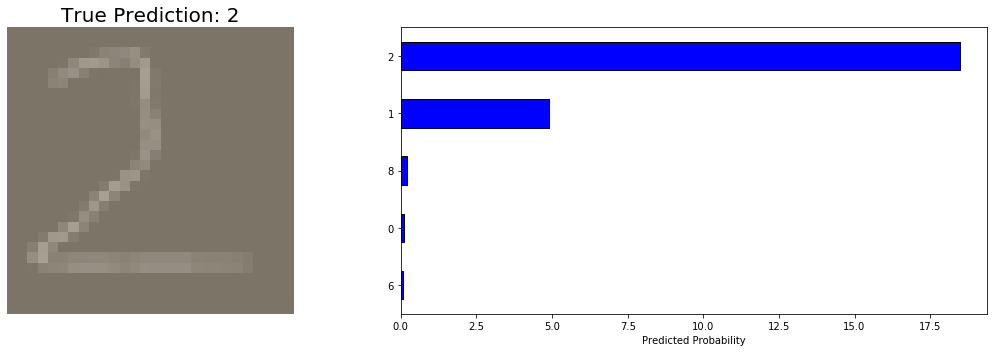

In [41]:
display_prediction("./digit_2.png", model, topk = 5)